Import libraries

In [ ]:
%pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ec725fb664d89118c342e0ad2ee2a5bc73633fc1dd6ebb0a930f347da3f10b63
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import pandas as pd
import math
import yfinance as yf
import numpy as np
import datetime
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('fivethirtyeight')
import pandas_datareader.data as web
import ta

In [ ]:
# print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


# Stock Market Data

## Exploratory Data Analysis - Analyse data from 2012 - 2025

Download Northern Oil & Gas data from 2012 - 2025 in a dataframe using YahooFinance API

In [ ]:
starttime = datetime.datetime(2012, 1, 1)
endtime = datetime.datetime(2025, 4, 27)
ticker = "NOG"
df = yf.download(ticker, start=starttime, end=endtime)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NOG,NOG,NOG,NOG,NOG
Date,,,,,
2012-01-03,216.132462,220.474215,212.745899,212.919567,201990
2012-01-04,223.339813,224.121324,214.048450,218.737539,77410
2012-01-05,218.650711,220.995255,210.748714,218.911219,128430
2012-01-06,210.314529,221.342580,210.314529,221.342580,92800
2012-01-09,212.919586,218.563866,208.838341,212.572251,75170


Shape and columns of the downloaded data

In [ ]:
print('Shape of the data downloaded ===>', df.shape)
print('\nColumns in the data downloaded ===>', df.columns)

Shape of the data downloaded ===> (3348, 5)

Columns in the data downloaded ===> MultiIndex([( 'Close', 'NOG'),
            (  'High', 'NOG'),
            (   'Low', 'NOG'),
            (  'Open', 'NOG'),
            ('Volume', 'NOG')],
           names=['Price', 'Ticker'])


Arranging dataframe with headers

In [ ]:
headers_as_rows = pd.DataFrame([df.columns.tolist()])
cols = [col[0] for col in headers_as_rows.iloc[0].to_list()]
df.columns = cols
df.reset_index(inplace=True)
df

,Date,Close,High,Low,Open,Volume
0,2012-01-03,216.132462,220.474215,212.745899,212.919567,201990
1,2012-01-04,223.339813,224.121324,214.048450,218.737539,77410
2,2012-01-05,218.650711,220.995255,210.748714,218.911219,128430
3,2012-01-06,210.314529,221.342580,210.314529,221.342580,92800
4,2012-01-09,212.919586,218.563866,208.838341,212.572251,75170
...,...,...,...,...,...,...
3343,2025-04-21,23.090000,23.850000,22.920000,23.510000,1481300
3344,2025-04-22,23.559999,23.950001,23.030001,23.620001,1438400
3345,2025-04-23,23.430000,24.650000,23.219999,24.270000,1410000
3346,2025-04-24,23.750000,23.969999,23.500000,23.809999,1029500


EDA function to understand the stats of the data

In [ ]:
def initial_eda(data, columns):
  eda_results = {
    'Metric Applied on': [],
    'Mean': [],
    'Median': [],
    'Mode': [],
    'Standard Deviation': [],
    'Variance': [],
    'Minimum': [],
    'Maximum': [],
    'Range': [],
    'Skewness': [],
    'Kurtosis': [],
    'Coefficient of Variation': []
  }
  numeric_data = data.select_dtypes(include=['number'])
  for col in numeric_data.columns:
    eda_results['Metric Applied on'].append(col)
    eda_results['Mean'].append(data[col].mean())
    eda_results['Median'].append(data[col].median())
    eda_results['Mode'].append(data[col].mode())
    eda_results['Standard Deviation'].append(data[col].std())
    eda_results['Variance'].append(data[col].var())
    eda_results['Minimum'].append(data[col].min())
    eda_results['Maximum'].append(data[col].max())
    eda_results['Range'].append(data[col].max() - data[col].min())
    eda_results['Skewness'].append(data[col].skew())
    eda_results['Kurtosis'].append(data[col].kurtosis())
    eda_results['Coefficient of Variation'].append(data[col].std() / data[col].mean())
  eda_df = pd.DataFrame(eda_results)
  return eda_df

Make the data look pretty format :)

In [ ]:
def pretty_print_eda(data, columns):
  eda = initial_eda(data, columns)
  return eda

Print EDA in a pretty table

In [ ]:
pretty_print_eda(df, ['Close','High','Low','Open','Volume'])

,Metric Applied on,Mean,Median,Mode,Standard Deviation,Variance,Minimum,Maximum,Range,Skewness,Kurtosis,Coefficient of Variation
0,Close,50.876836,30.048892,"0 14.327784 Name: Close, dtype: float64",49.675326,2.467638e+03,2.952392,2.350625e+02,2.321102e+02,1.422436,0.895751,0.976384
1,High,52.052004,30.570945,"0 14.761959 Name: High, dtype: float64",50.515943,2.551860e+03,3.117379,2.431382e+02,2.400208e+02,1.421166,0.904469,0.970490
2,Low,49.725738,29.273281,"0 13.893608 Name: Low, dtype: float64",48.837098,2.385062e+03,2.908975,2.271606e+02,2.242516e+02,1.423381,0.884409,0.982129
3,Open,50.965442,29.981162,"0 14.327784 Name: Open, dtype: float64",49.743037,2.474370e+03,3.091328,2.370598e+02,2.339684e+02,1.424857,0.907581,0.976015
4,Volume,610343.270609,366705.000000,0 44520 1 66970 2 75450 3 79040...,786294.158705,6.182585e+11,16840.000000,1.716580e+07,1.714896e+07,5.449917,74.350551,1.288282


### Summary Explanation

- Mean : Averge value, affected by outliers. Average prices is ~$50. On an average 582k shares traded daily.

- Median : Middle value, not affected by outliers. Median value for the prices is ~$30.

- Mode : Most occuring values for each of the prices, volumes of trades daily.

- Standard Deviation : Deviation from mean. In data from 2012-2025, all the prices- close, high, low and open show very high volatility ~$50. Trades volatitlity also very high - 786k per day.

- Variance : Spread of the data. High variance in prices around ~2500. Enormous variance in the trades done daily - 618 billion.

- Minimum : Minimum stock price. Extremely cheap $2.95 close price at a point in the 10 years of analysis probably in the early days or after a crash.

- Maximum : Maximum stock price. $235.06 close price when the stock grew exponentially.

- Range : Enormous spread for prices = $232.11. Huge spread for daily trades = 17.15 million shares slow days vs busy days.

- Skewness : Strong positive skew, many low/moderate prices, few high prices. Extremely positive trades volumne data. In a positively skewed distribution, the mean is typically greater than the median. A skewness of 5.94 is very high, suggesting that the few extreme high values have a substantial impact on the mean.

- Kurtosis : measure of the tailedness of a distribution (how often outliers occur). Lighter tails for prices than normal. Slightly fewer extreme outliers than a normal distribution. For volume extremely heavy tails — confirms presence of huge extreme events (massive trading days).

- Coefficient of Variantion : relative spread or variability of data within a dataset - ratio of the standard deviation to the mean. Stock's volatility is large for all prices. Volume is even more volatile than price itself!

### Conclusion
1. All the prices Close, Open, High, Low behave in a similar fashion statistically - high volatility, strong right tailed behavior, highly unstable average prices and very large historical range.
2. Volume is not normally distributed at all — it’s extreme.
3. Most days have moderate volume, but few days see 10x or 50x higher trading — these are probably linked to news, earnings releases, acquisitions, oil shocks, etc.
4. High kurtosis and skewness tell us volume is dominated by outlier events.

**Stock Prices - Prices fluctuate a lot but behave fairly predictably (positively skewed growth-type stock). High Volatility, Right Tail, Some Stability**

**Volume - unpredictable and extreme — some days NOG experiences absolutely massive activity. Extreme Events, News-Driven, Highly Unstable**



Distribution Plots for visualizing our analysis

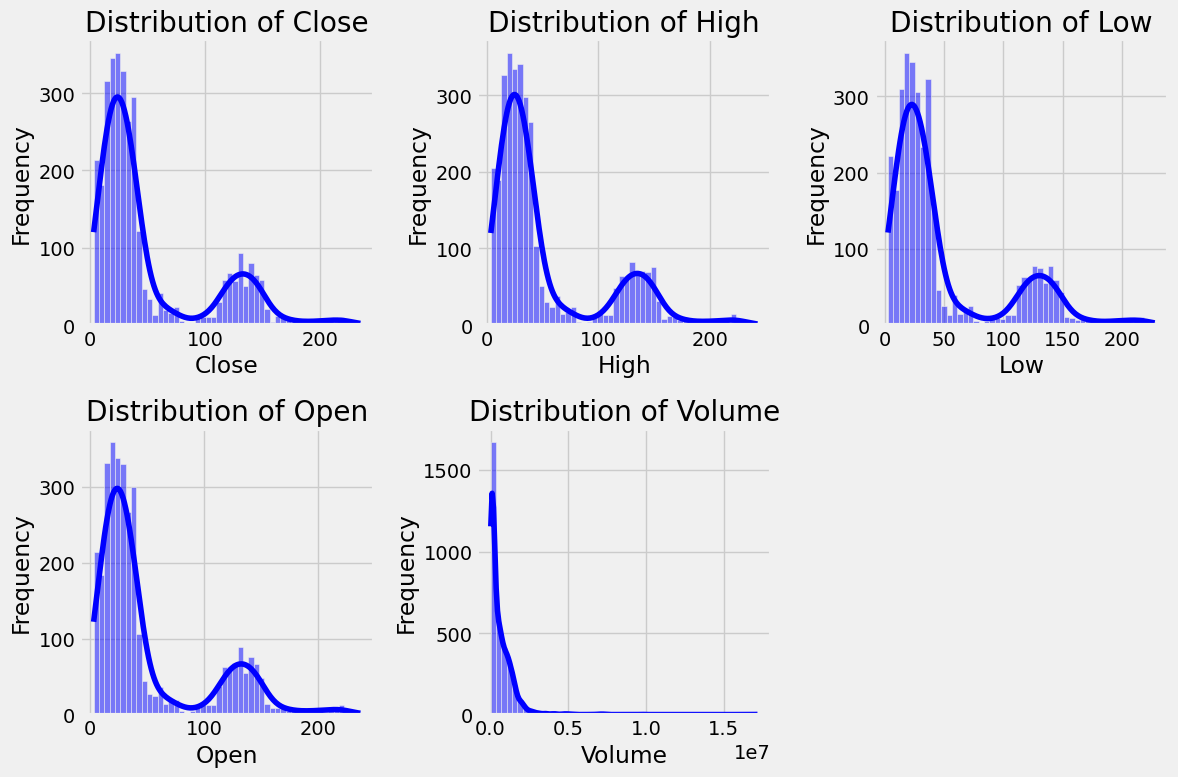

In [ ]:
plt.figure(figsize=(12, 8))
feats = ['Close', 'High', 'Low', 'Open', 'Volume']

for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  sns.histplot(df[feature], kde=True, bins=50, color='blue')
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Skewness for prices and huge skew for volume

Boxplot for Outliers

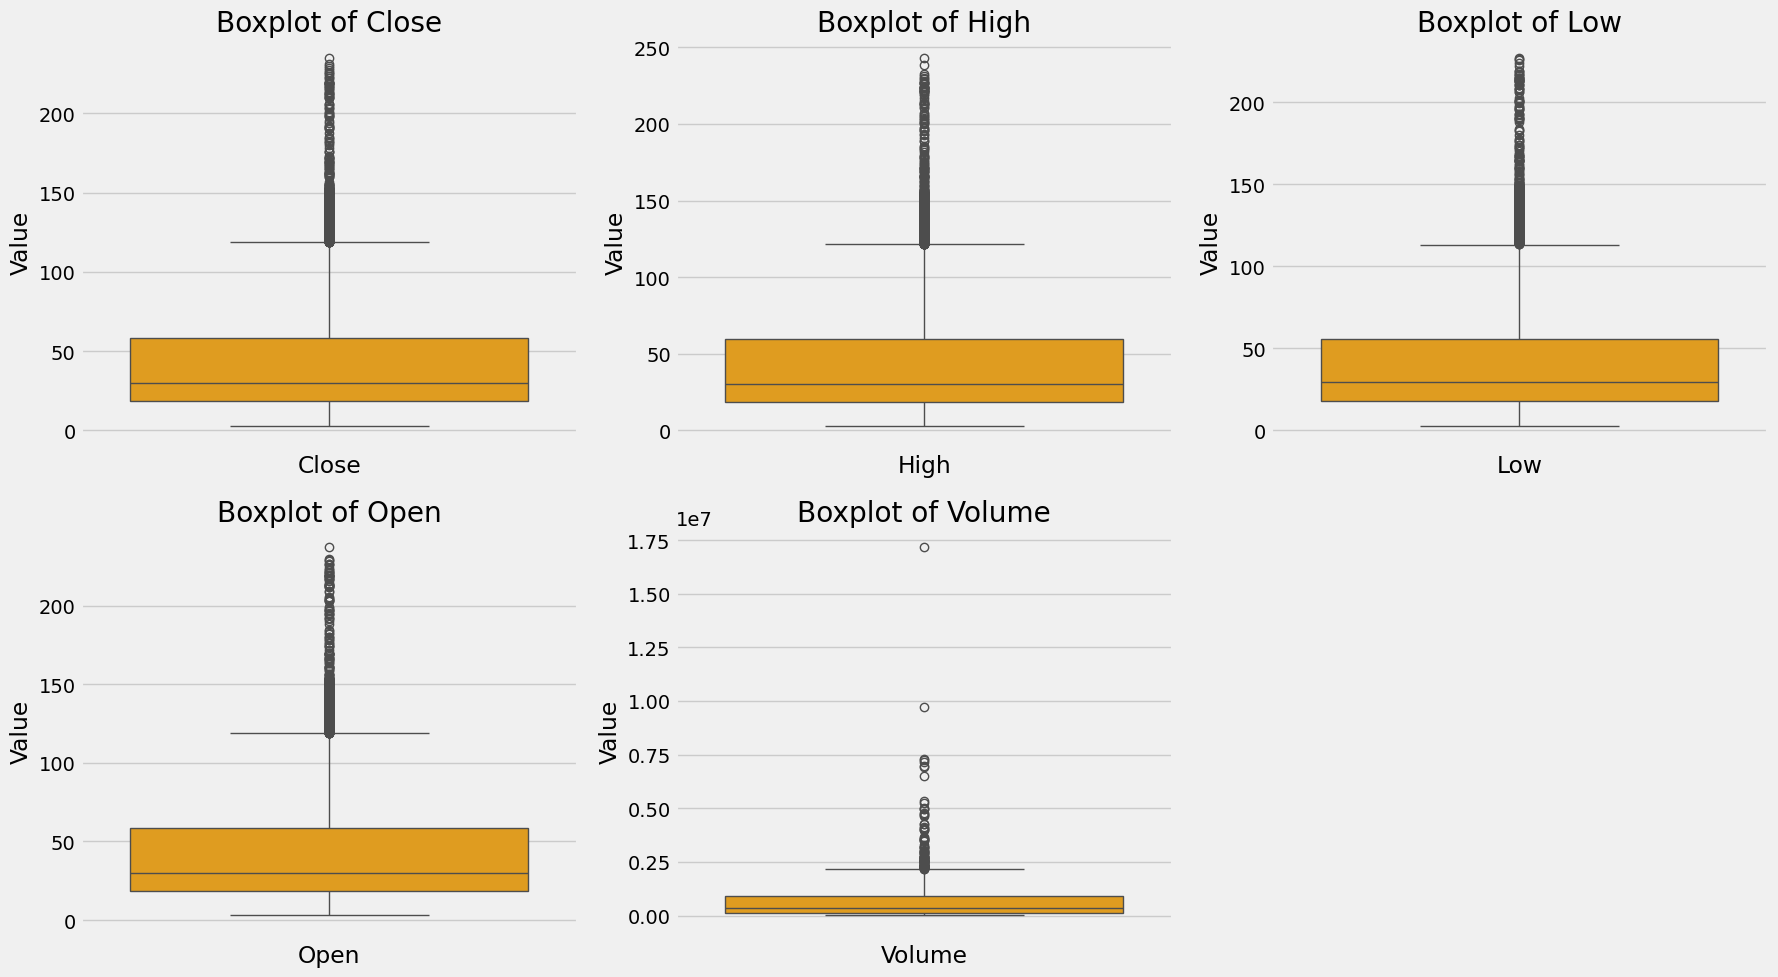

In [ ]:
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  sns.boxplot(df[feature], color='orange')
  plt.title(f'Boxplot of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Value')
plt.tight_layout()
plt.show()

Rolling Window and Rolling Volatility

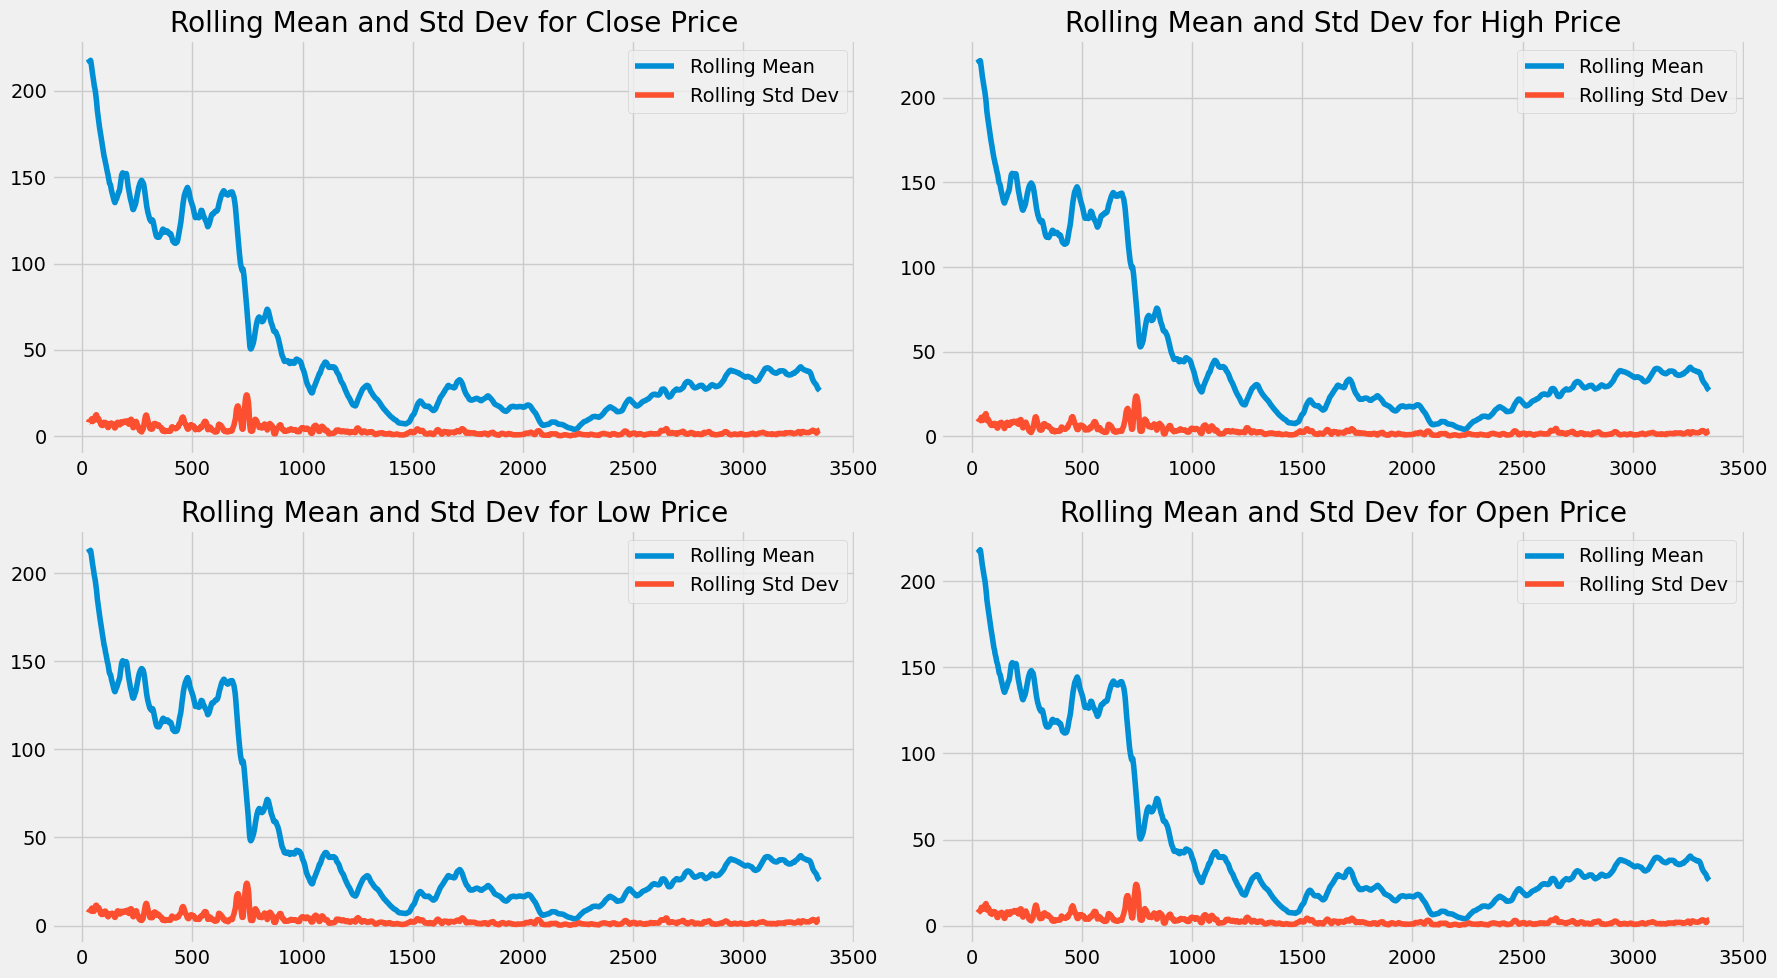

In [ ]:
window_size = 30
plt.figure(figsize=(18, 10))

for idx, feature in enumerate(feats[:-1]):
  plt.subplot(2,2,idx+1)
  df[feature].rolling(window=window_size).mean().plot(label='Rolling Mean')
  df[feature].rolling(window=window_size).std().plot(label='Rolling Std Dev')
  plt.title(f'Rolling Mean and Std Dev for {feature} Price')
  # plt.xlabel('Date')
  # plt.ylabel(feature)
  plt.legend()
plt.tight_layout()
plt.show()

Rolling Mean shows trend shifts .

Rolling STD shows periods of market calm vs turbulence.




Correlation Heatmap

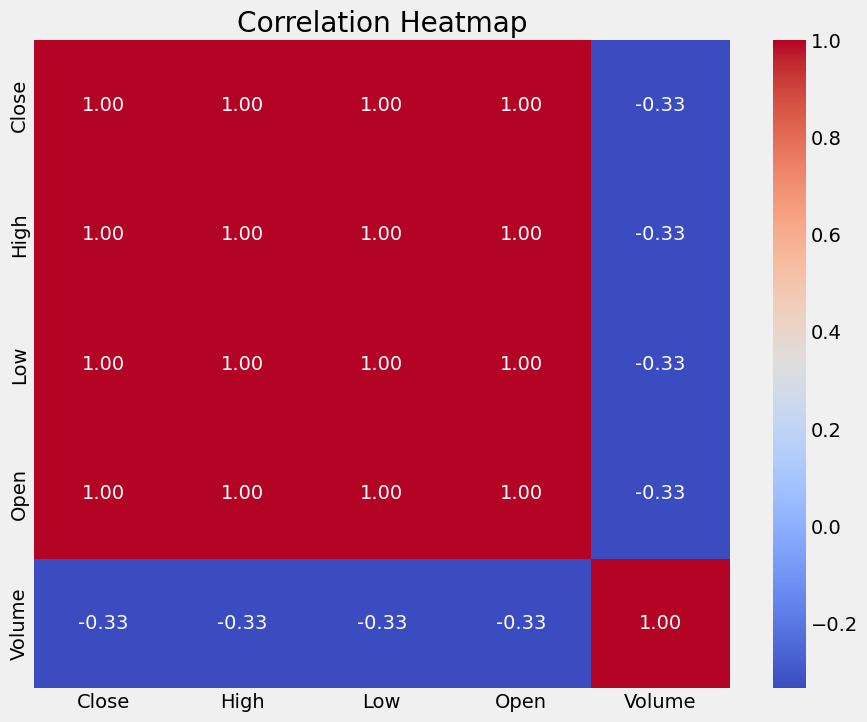

In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = df[feats].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

QQ-Plots

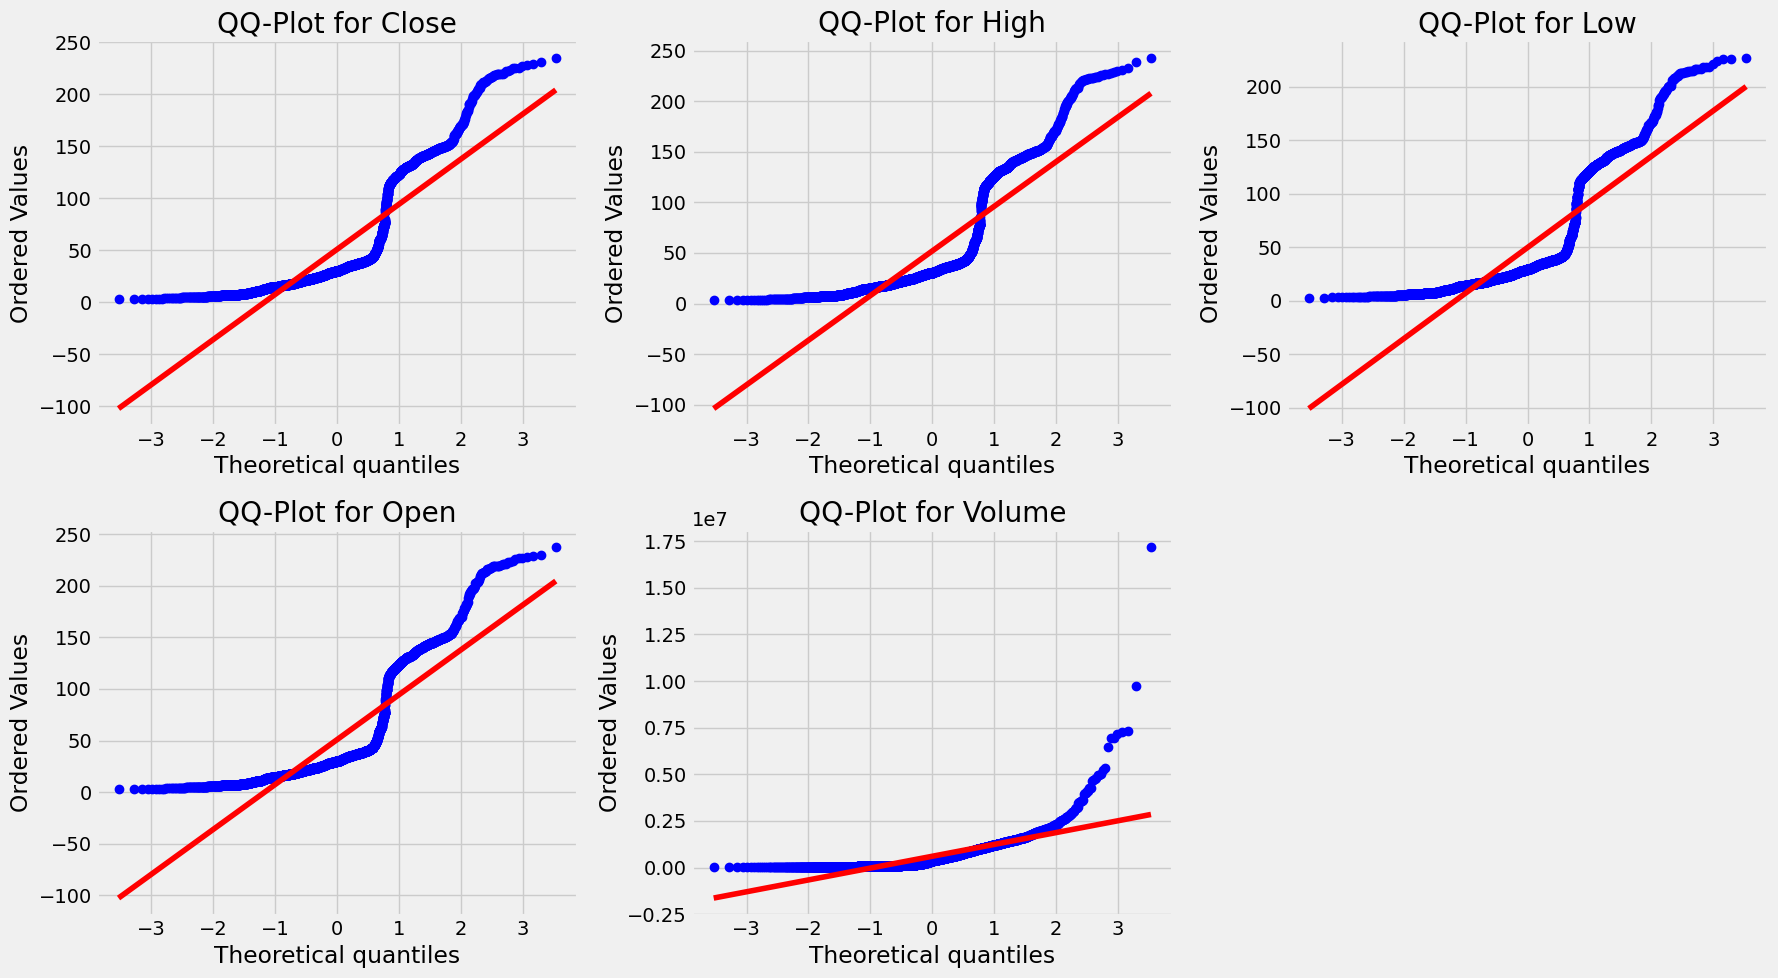

In [ ]:
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  stats.probplot(df[feature], dist='norm', plot=plt)
  plt.title(f'QQ-Plot for {feature}')
plt.tight_layout()
plt.show()

The points deviate heavily from the straight line → non-normal distribution confirmed.

### The above analysis is from 2012 until today. For a more recent daily prediction we should consider a lookback window of 6 months to 2 years. Reasons for reducing the window size are:
- Markets evolve — conditions 10 years ago are not the same today (due to macro changes, technology, oil demand, Fed policies, etc.).
- Recent patterns are MUCH more relevant for short-term prediction (like predicting tomorrow).
- Old data introduces noise, reduces model's sharpness, and hurts your prediction accuracy.

## Exploratory Data Analysis - Analyze data from 2023 - 2025

In [ ]:
starttime = datetime.datetime(2023, 4, 27)
endtime = date.today()
ticker = "NOG"
df = yf.download(ticker, start=starttime, end=endtime)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NOG,NOG,NOG,NOG,NOG
Date,,,,,
2023-04-27,29.507429,29.863600,29.023401,29.662682,787200
2023-04-28,30.292828,30.575939,29.279112,29.534824,742000
2023-05-01,30.438955,30.722064,29.626151,29.836200,1147100
2023-05-02,29.333906,30.155841,28.712891,30.128445,1189600
2023-05-03,28.311058,29.206052,28.219732,28.667229,2064100


In [ ]:
headers_as_rows = pd.DataFrame([df.columns.tolist()])
cols = [col[0] for col in headers_as_rows.iloc[0].to_list()]
df.columns = cols
df.reset_index(inplace=True)
df[:2]

,Date,Close,High,Low,Open,Volume
0,2023-04-27,29.507429,29.863600,29.023401,29.662682,787200
1,2023-04-28,30.292828,30.575939,29.279112,29.534824,742000


In [ ]:
pretty_print_eda(df, ['Close','High','Low','Open','Volume'])

,Metric Applied on,Mean,Median,Mode,Standard Deviation,Variance,Minimum,Maximum,Range,Skewness,Kurtosis,Coefficient of Variation
0,Close,3.489607e+01,3.567131e+01,0 30.210638 1 33.066757 2 33.36409...,4.184781,1.751239e+01,20.600000,4.235559e+01,2.175559e+01,-0.862858,0.541870,0.119921
1,High,3.541366e+01,3.624328e+01,0 22.700001 1 23.180000 2 23.26...,4.142150,1.715741e+01,22.700001,4.315420e+01,2.045420e+01,-0.807771,0.338086,0.116965
2,Low,3.442318e+01,3.521048e+01,0 19.879999 1 20.379999 2 21.10...,4.219054,1.780041e+01,19.879999,4.222898e+01,2.234898e+01,-0.923162,0.718502,0.122564
3,Open,3.494854e+01,3.576777e+01,"0 23.309999 Name: Open, dtype: float64",4.204056,1.767409e+01,20.170000,4.263802e+01,2.246802e+01,-0.851247,0.520151,0.120293
4,Volume,1.460956e+06,1.278600e+06,0 790400 1 828400 2 1034300 3 10...,807595.131875,6.522099e+11,396000.000000,7.156800e+06,6.760800e+06,3.245416,15.750682,0.552785


### Summary Explanation

Prices

- Sknewness - All the price columns have negative skewness. Negative skewness means the left tail is longer: Occasional sharp drops are more likely than sharp rises. Prices mostly stay stable or rise slightly, but some rare times they can crash hard.
- Kurtosis - More prone to outliers than a perfect normal distribution. Combined with negative skewness: these outliers could be sharp downward moves.
- Range - The stock has historically had big movements. Since skew is negative, the big movements are biased towards drops.
- Coefficient of Variation - ~11% pretty stable.

Volume

- Mean (1.45 million) is significantly greater than median (1.27 million) : sign of a positively skewed distribution. Hence, most days volume is normal or low, but some days are extremely high, pulling the mean up.
- Skewness - A skewness > +1.0 is considered strongly positively skewed. Few days with extremely large volumes — i.e., activity spikes. The tail is stretched to the right → higher volume days.
- Kurtosis - 16.4 is extremely high kurtosis, huge-volume days are extreme outliers.
- Range - That is an enormous spread — means some days volume exploded compared to typical days.
- Coefficient of Variance - 55% shows massive instability and spikes relative to the average volume.

Distribution Plots for visualizing our analysis

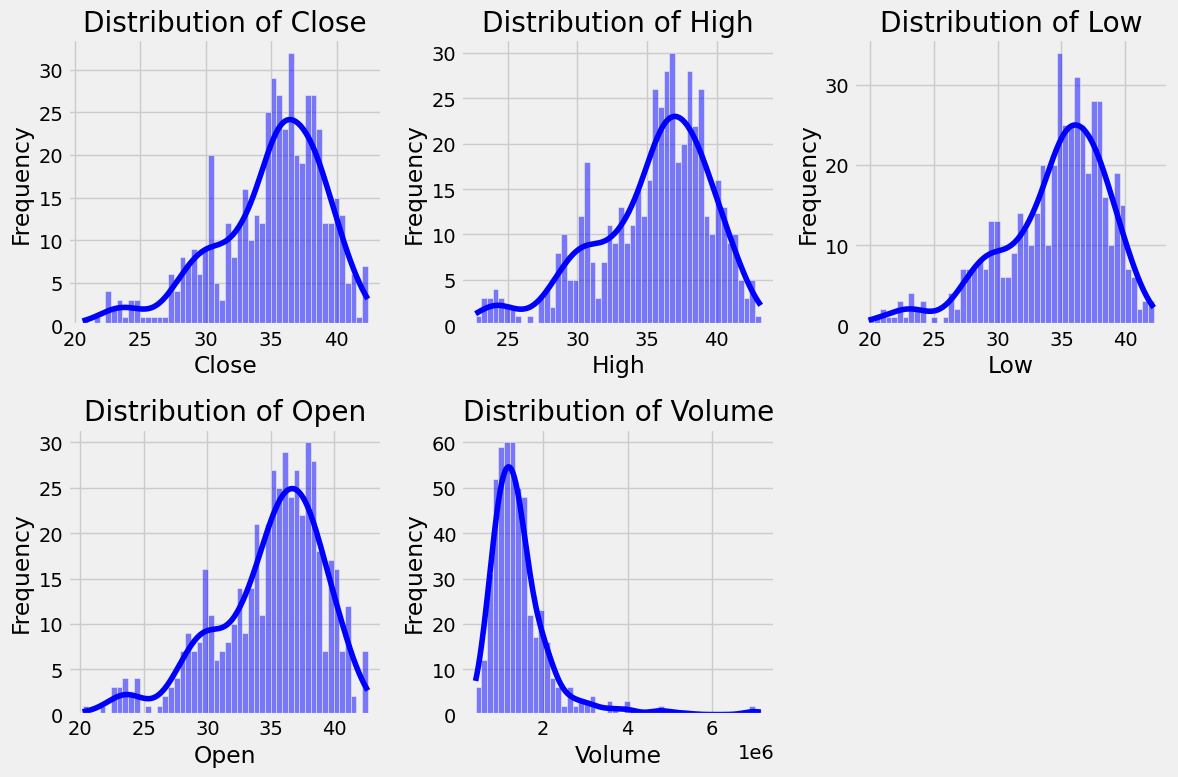

In [ ]:
plt.figure(figsize=(12, 8))
feats = ['Close', 'High', 'Low', 'Open', 'Volume']

for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  sns.histplot(df[feature], kde=True, bins=50, color='blue')
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Boxplot for Outliers

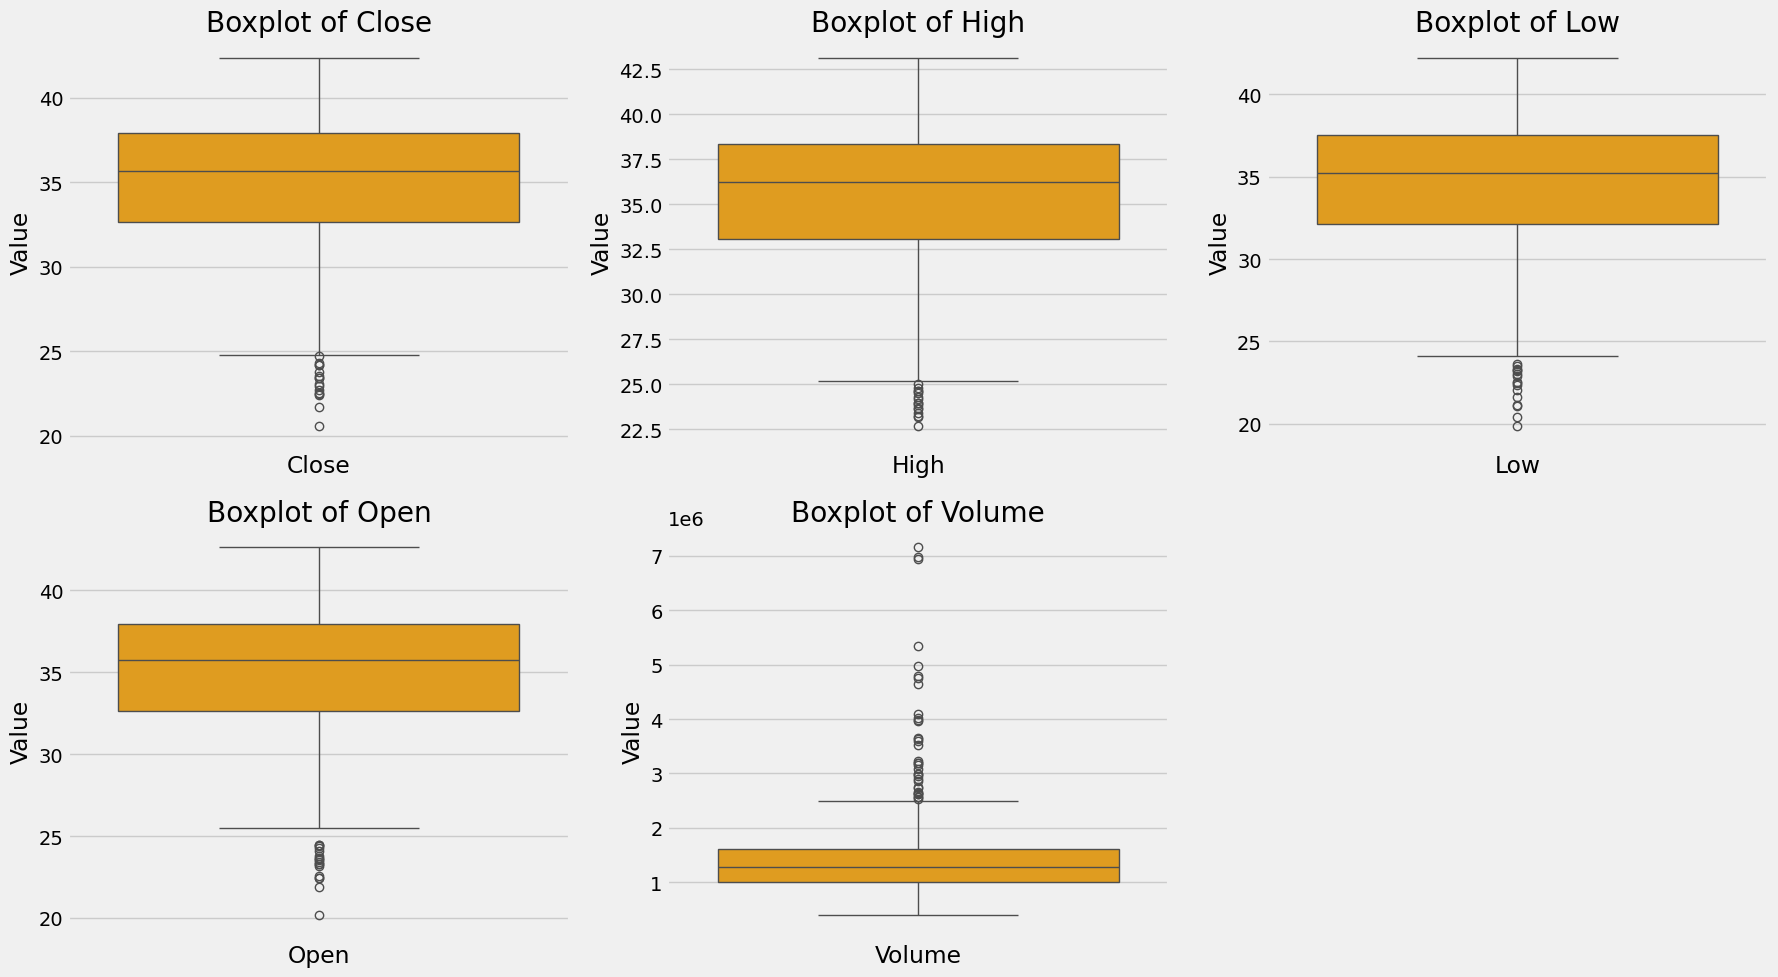

In [ ]:
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  sns.boxplot(df[feature], color='orange')
  plt.title(f'Boxplot of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Value')
plt.tight_layout()
plt.show()

Rolling Window and Rolling Volatility

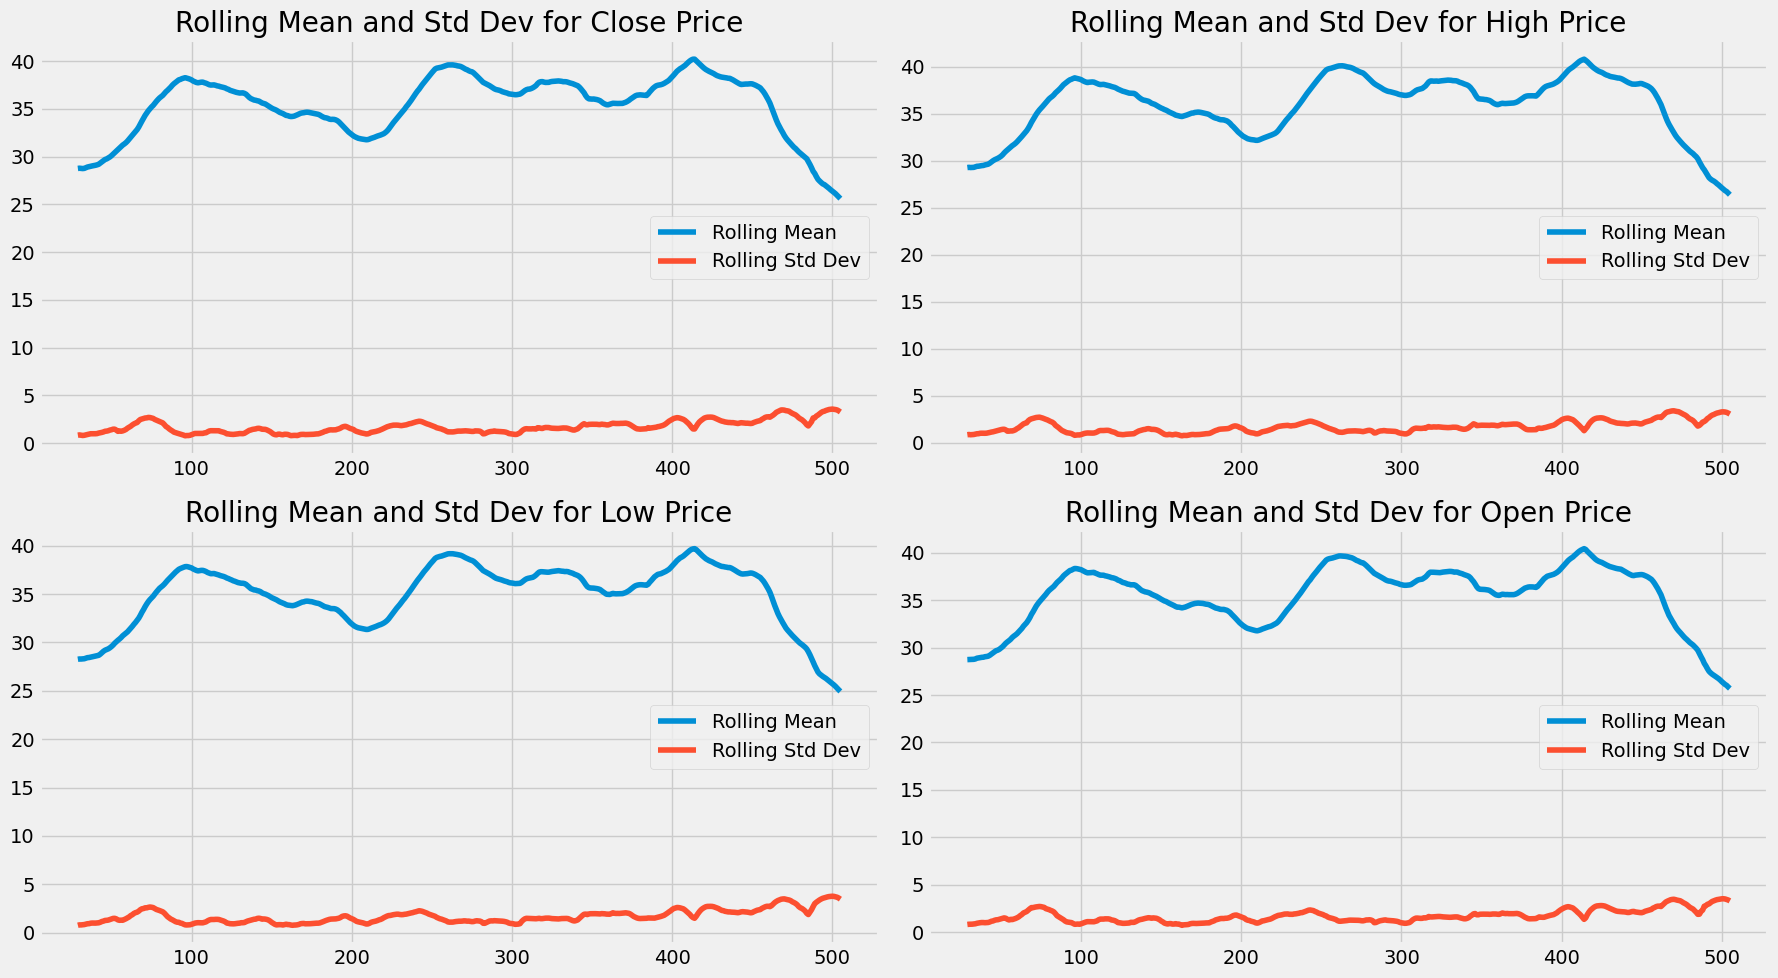

In [ ]:
window_size = 30
plt.figure(figsize=(18, 10))

for idx, feature in enumerate(feats[:-1]):
  plt.subplot(2,2,idx+1)
  df[feature].rolling(window=window_size).mean().plot(label='Rolling Mean')
  df[feature].rolling(window=window_size).std().plot(label='Rolling Std Dev')
  plt.title(f'Rolling Mean and Std Dev for {feature} Price')
  # plt.xlabel('Date')
  # plt.ylabel(feature)
  plt.legend()
plt.tight_layout()
plt.show()

Correlation Heatmap

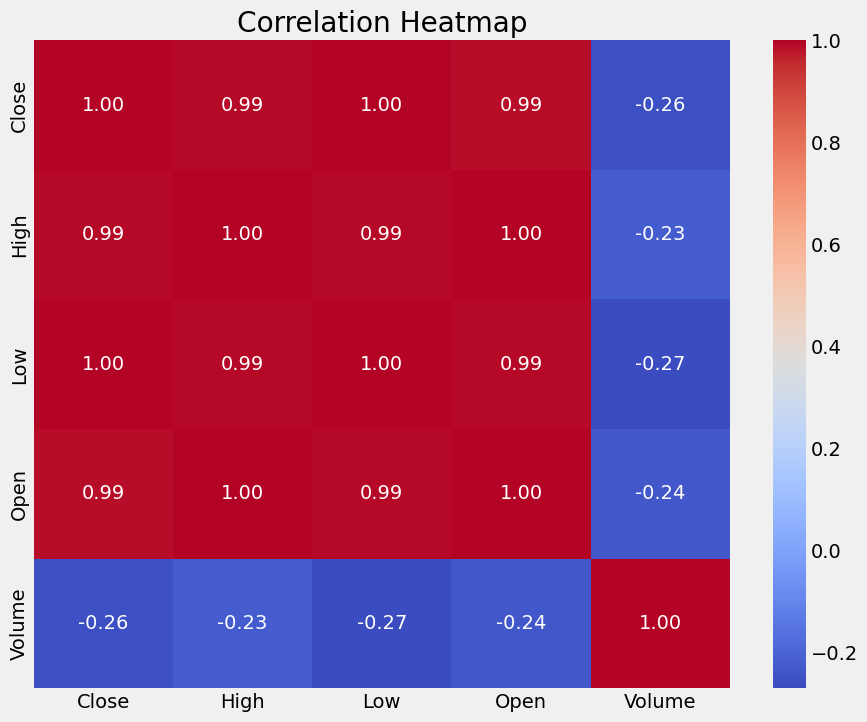

In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = df[feats].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

QQ-Plots

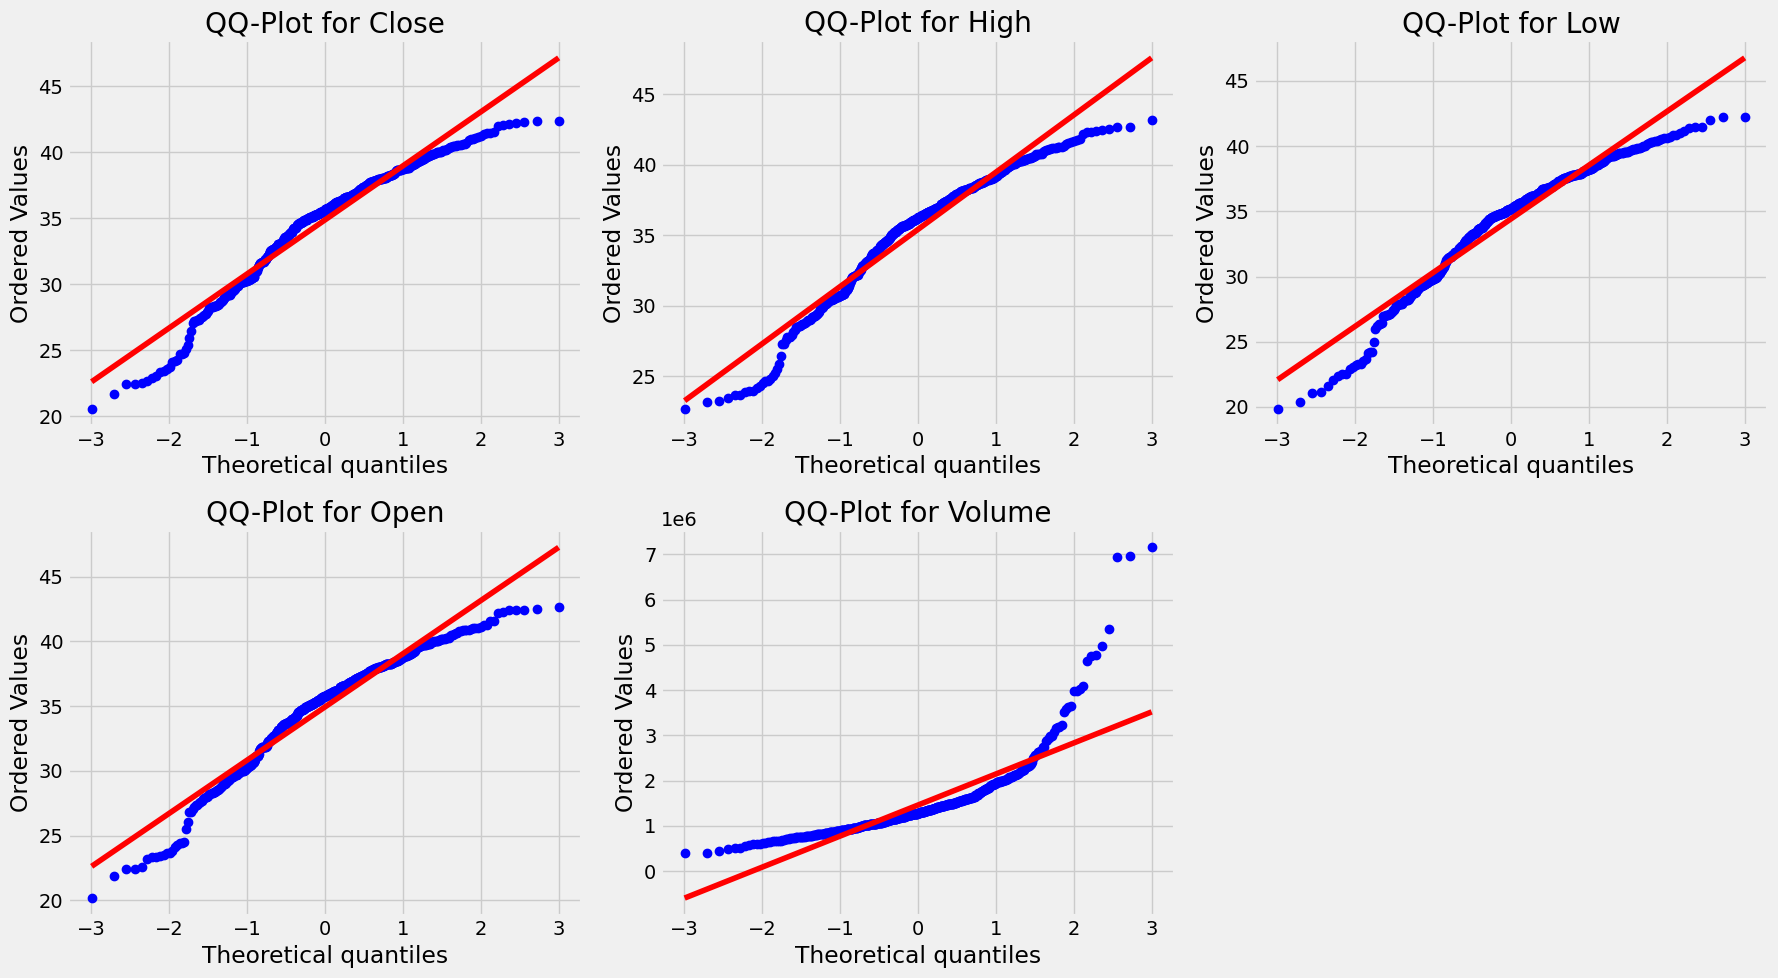

In [ ]:
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(feats):
  plt.subplot(2, 3, idx+1)
  stats.probplot(df[feature], dist='norm', plot=plt)
  plt.title(f'QQ-Plot for {feature}')
plt.tight_layout()
plt.show()

### Conclusion

**Price distribution is volatile, negatively skewed, and prone to sudden large downward moves but often recovers over time. Potentially profitable for long-term, cautious investors**

**Volume distribution is highly asymmetric, fat-tailed, and shows extreme outliers.**

## Feature Engineering

Moving averages on closing price: Captures short- and long-term trends in stock prices.

To capture trends, seasonality, or other temporal patterns

In [ ]:
df['ma_10'] = pd.DataFrame(df['Close'].rolling(10).mean())
# df['ma_20'] = pd.DataFrame(df['Close'].rolling(20).mean())
# df['ma_30'] = pd.DataFrame(df['Close'].rolling(30).mean())
# df['ma_40'] = pd.DataFrame(df['Close'].rolling(40).mean())
df['ma_50'] = pd.DataFrame(df['Close'].rolling(50).mean())

Plot the rolling window last 200 data points

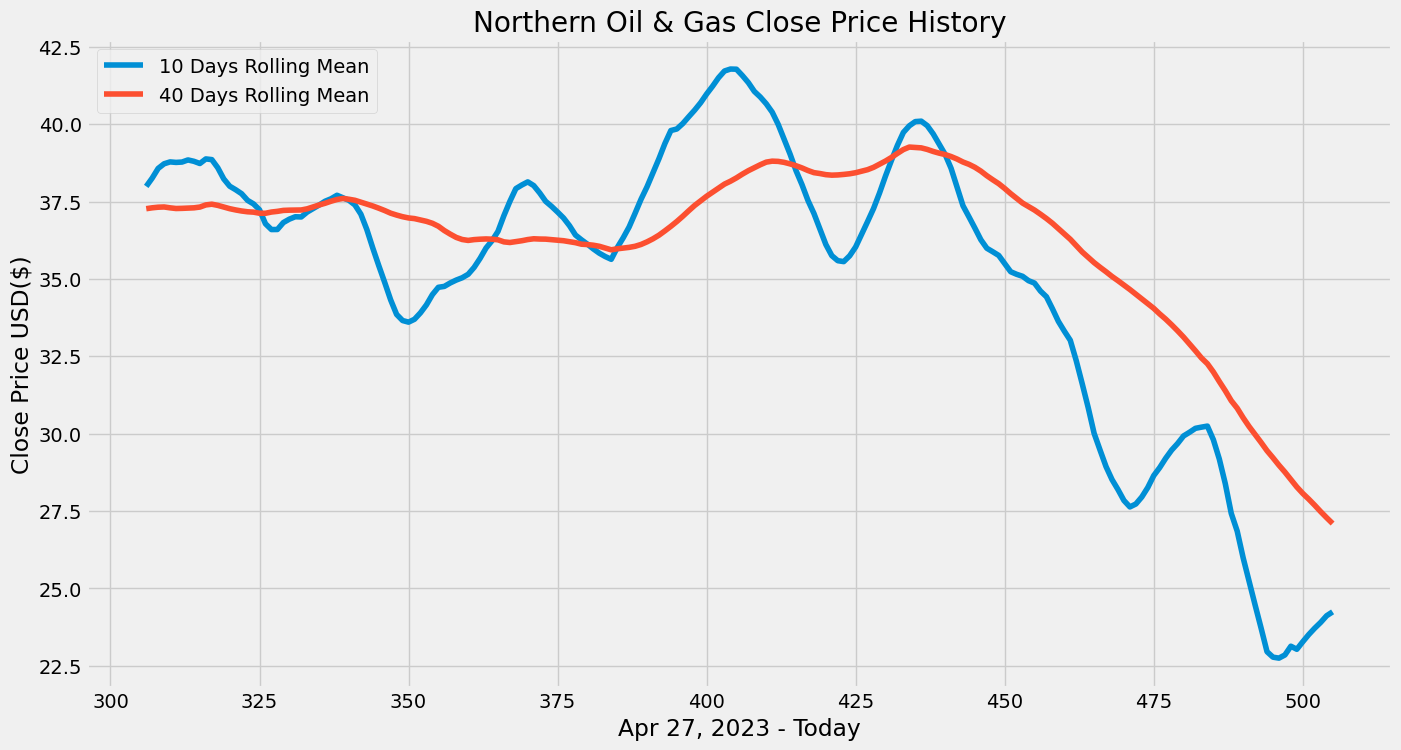

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(df['ma_10'].tail(200), label='10 Days Rolling Mean')
# plt.plot(df['ma_20'].tail(200), label='20 Days Rolling Mean')
# plt.plot(df['ma_30'].tail(200), label='30 Days Rolling Mean')
plt.plot(df['ma_50'].tail(200), label='40 Days Rolling Mean')
plt.title('Northern Oil & Gas Close Price History')
plt.xlabel('Apr 27, 2023 - Today')
plt.ylabel('Close Price USD($)')
plt.legend(loc='upper left')
plt.show()

Volatility (Daily Percentage Change and Rolling Standard Deviation): Measures the stock’s price fluctuation over a rolling 10, 20, 30, 40-day period

In [ ]:
df['daily_change'] = df['Close'].pct_change()
df['volatility_10'] = df['daily_change'].rolling(10).std()
# df['volatility_20'] = df['daily_change'].rolling(20).std()
# df['volatility_30'] = df['daily_change'].rolling(30).std()
# df['volatility_40'] = df['daily_change'].rolling(40).std()

Relative Strength Index (RSI): Indicates overbought or oversold conditions (values over 70 imply overbought, under 30 imply oversold)

In [ ]:
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

Bollinger Bands are a technical analysis tool that helps you visualize the volatility and potential overbought or oversold conditions of a stock

In [ ]:
df['RSI_14'] = calculate_rsi(df['Close'], window=14)

# Calculate Bollinger Bands
bb_indicator = ta.volatility.BollingerBands(close=df['Close'], window=20)
df['bb_high'] = bb_indicator.bollinger_hband()
df['bb_low'] = bb_indicator.bollinger_lband()

Momentum: Quantifies the rate of price changes over a specified time frame (10 days in this case)

To capture trends, seasonality, or other temporal patterns

In [ ]:
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)  # Price difference over 10 days
# df['Momentum_20'] = df['Close'] - df['Close'].shift(20)
# df['Momentum_30'] = df['Close'] - df['Close'].shift(30)

Volume-Weighted Average Price (VWAP) = (Cumulative Sum of (Price * Volume)) / (Cumulative Sum of Volume)

In [ ]:
df['Cumulative_Price_Volume'] = (df['Close'] * df['Volume']).cumsum()
df['Cumulative_Volume'] = df['Volume'].cumsum()
df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']

In [ ]:
df.tail()

,Date,Close,High,Low,Open,Volume,ma_10,ma_50,daily_change,volatility_10,RSI_14,bb_high,bb_low,Momentum_10,Cumulative_Price_Volume,Cumulative_Volume,VWAP
501,2025-04-28,24.799999,24.820000,24.100000,24.100000,2077600,23.504,27.881185,0.026490,0.026696,57.444000,29.792459,18.925541,2.320000,2.510771e+10,729224600,34.430698
502,2025-04-29,24.760000,25.030001,24.219999,24.440001,3234100,23.710,27.684438,-0.001613,0.026957,65.662651,28.814316,19.356684,2.059999,2.518779e+10,732458700,34.387998
503,2025-04-30,24.299999,26.400000,23.639999,26.080000,3074800,23.897,27.476914,-0.018578,0.027609,47.708331,27.727276,19.886724,1.869999,2.526251e+10,735533500,34.345827
504,2025-05-01,25.080000,25.469999,24.250000,24.469999,1960400,24.112,27.280851,0.032099,0.028323,72.826089,26.012732,21.049268,2.150000,2.531167e+10,737493900,34.321196
505,2025-05-02,25.440001,25.860001,25.010000,25.490000,1749962,24.237,27.092383,0.014354,0.023574,71.264372,25.893543,21.116457,1.250000,2.535619e+10,739243862,34.300173


# Macroeconomic Data
Fetch crude oil prices from FRE: this indicator is economy-wide and not specific to any one company's performance.

FRED’s series "DCOILWTICO" provides the daily spot price of West Texas Intermediate (WTI) crude oil. For a company like NOG, which operates in the oil and gas sector, crude oil prices are highly significant. Changes in crude oil prices can directly impact NOG’s revenues, costs, and overall stock performance.

In [ ]:
# Download Crude Oil Prices and Federal Funds Rate from FRED using pandas_datareader
oil_prices = web.DataReader('DCOILWTICO', 'fred', starttime, endtime)
oil_prices.reset_index(inplace=True)
oil_prices.rename(columns={'DATE': 'Date', 'DCOILWTICO': 'Crude_Oil'}, inplace=True)
oil_prices['Date'] = pd.to_datetime(oil_prices['Date'])
oil_prices.sort_values('Date', inplace=True)

The series "FEDFUNDS" represents the effective federal funds rate, which is an important measure of monetary policy in the United States. The federal funds rate influences borrowing costs, which can affect everything from consumer spending to the financing costs for companies—including NOG.

In [ ]:
fed_funds = web.DataReader('FEDFUNDS', 'fred', starttime, endtime)
fed_funds.reset_index(inplace=True)
fed_funds.rename(columns={'DATE': 'Date', 'FEDFUNDS': 'Fed_Funds_Rate'}, inplace=True)
fed_funds['Date'] = pd.to_datetime(fed_funds['Date'])
fed_funds.sort_values('Date', inplace=True)

Concat the two macroeconomic data

In [ ]:
# Merge the two macroeconomic indicators into one DataFrame
macro_data = pd.merge_asof(oil_prices, fed_funds, on='Date', direction='backward')
macro_data.fillna(method='ffill', inplace=True)  # Forward fill any missing values

<ipython-input-95-31825c0c5527>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='ffill', inplace=True)  # Forward fill any missing values


## Merge Market Stock Data + Macroeconomic Data

In [ ]:
# Merge NOG stock data with the macroeconomic data on Date
merged_data = pd.merge_asof(df, macro_data, on='Date', direction='backward')
merged_data.fillna(method='ffill', inplace=True)

<ipython-input-96-0d5c28891512>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)


In [ ]:
merged_data.dropna(inplace=True)

In [ ]:
merged_data.shape

(457, 19)

In [ ]:
merged_data.tail()

,Date,Close,High,Low,Open,Volume,ma_10,ma_50,daily_change,volatility_10,RSI_14,bb_high,bb_low,Momentum_10,Cumulative_Price_Volume,Cumulative_Volume,VWAP,Crude_Oil,Fed_Funds_Rate
501,2025-04-28,24.799999,24.820000,24.100000,24.100000,2077600,23.504,27.881185,0.026490,0.026696,57.444000,29.792459,18.925541,2.320000,2.510771e+10,729224600,34.430698,63.3,4.33
502,2025-04-29,24.760000,25.030001,24.219999,24.440001,3234100,23.710,27.684438,-0.001613,0.026957,65.662651,28.814316,19.356684,2.059999,2.518779e+10,732458700,34.387998,63.3,4.33
503,2025-04-30,24.299999,26.400000,23.639999,26.080000,3074800,23.897,27.476914,-0.018578,0.027609,47.708331,27.727276,19.886724,1.869999,2.526251e+10,735533500,34.345827,63.3,4.33
504,2025-05-01,25.080000,25.469999,24.250000,24.469999,1960400,24.112,27.280851,0.032099,0.028323,72.826089,26.012732,21.049268,2.150000,2.531167e+10,737493900,34.321196,63.3,4.33
505,2025-05-02,25.440001,25.860001,25.010000,25.490000,1749962,24.237,27.092383,0.014354,0.023574,71.264372,25.893543,21.116457,1.250000,2.535619e+10,739243862,34.300173,63.3,4.33


Feature Columns for ML/ DL models with engineered date column as sin/cos

In [ ]:
feature_cols = ['High', 'Low', 'Volume', 'ma_10', 'ma_50', 'daily_change', 'volatility_10',
                'RSI_14', 'Momentum_10', 'VWAP', 'Crude_Oil', 'Fed_Funds_Rate']

Target column

In [ ]:
target = 'Close'

Divide X and y data using columns and split 80% train vs 20% test

In [ ]:
X = merged_data[feature_cols]
y = merged_data[target]

In [ ]:
split_index = int(len(merged_data) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [ ]:
merged_data[:2]

,Date,Close,High,Low,Open,Volume,ma_10,ma_50,daily_change,volatility_10,RSI_14,bb_high,bb_low,Momentum_10,Cumulative_Price_Volume,Cumulative_Volume,VWAP,Crude_Oil,Fed_Funds_Rate
49,2023-07-10,32.317417,32.372832,31.707829,31.855608,1479000,31.306368,29.524195,0.017743,0.017569,64.188587,32.442681,28.879798,3.029175,2.376390e+09,81213700,29.260955,73.05,5.12
50,2023-07-11,32.465202,32.539090,31.984920,32.409784,1245700,31.567441,29.583350,0.004573,0.017319,65.658447,32.705150,28.850092,2.610737,2.416832e+09,82459400,29.309361,74.87,5.12


# Baseline Model

In [ ]:
# set index Date
# merged_data = merged_data.set_index('Date')
# merged_data.set_index('Date', inplace=True)
# Shift 'Close' to create the Target Variable: Close_next_day
merged_data['Close_predicted'] = merged_data['Close'].shift(1).rolling(window=3).mean()
merged_data.dropna(inplace=True)
# Prepare true and predicted values
y_true = merged_data['Close']
y_pred = merged_data['Close_predicted']

In [ ]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

In [ ]:
print("\nBaseline Model (Predict Average Close) Evaluation Metrics")
print("="*60)
print(f"{'Mean Absolute Error (MAE)':35}: {mae:10.4f}")
print(f"{'Mean Squared Error (MSE)':35}: {mse:10.4f}")
print(f"{'Root Mean Squared Error (RMSE)':35}: {rmse:10.4f}")
print(f"{'R-squared (R² Score)':35}: {r2:10.4f}")
print("="*60)


Baseline Model (Predict Average Close) Evaluation Metrics
Mean Absolute Error (MAE)          :     0.7809
Mean Squared Error (MSE)           :     1.1577
Root Mean Squared Error (RMSE)     :     1.0759
R-squared (R² Score)               :     0.9265


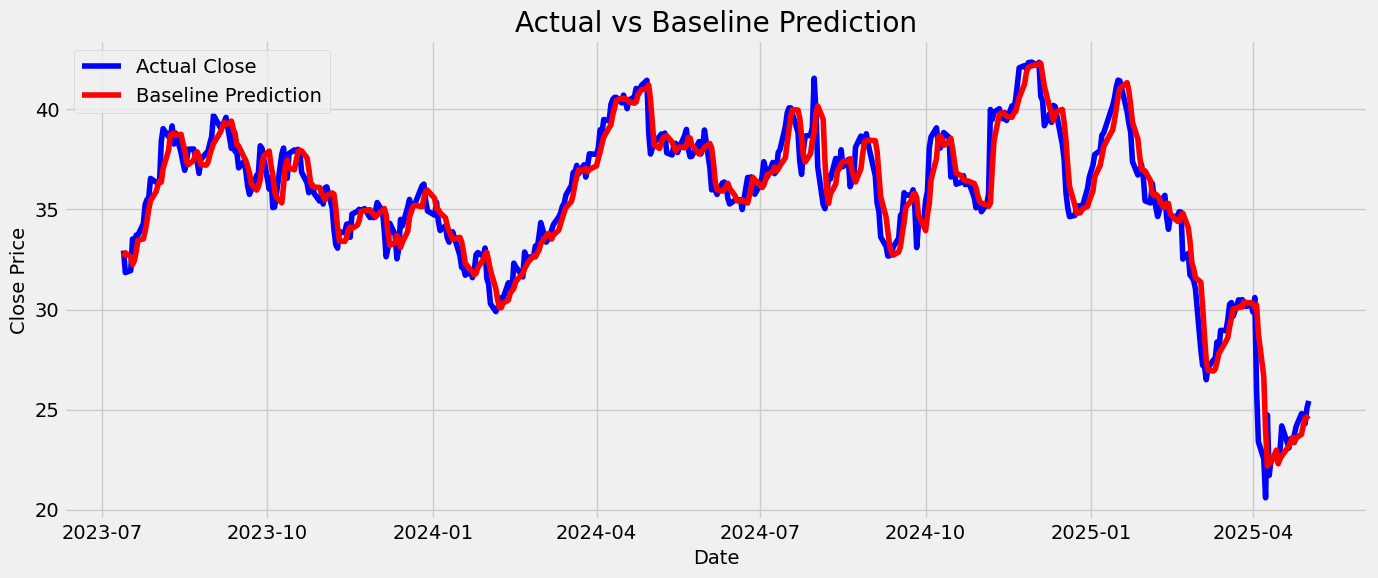

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(merged_data['Date'], merged_data['Close'], label='Actual Close', color='blue')
plt.plot(merged_data['Date'], merged_data['Close_predicted'], label='Baseline Prediction', color='red')
plt.title('Actual vs Baseline Prediction')
plt.xlabel('Date',  fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Linear Regression

In [ ]:
features = [
        'High', 'Low', 'Open', 'Volume', 'ma_10', 'ma_50', 'daily_change',
    'volatility_10', 'RSI_14', 'bb_high', 'bb_low', 'Momentum_10',
    'Cumulative_Price_Volume', 'Cumulative_Volume', 'VWAP', 'Crude_Oil', 'Fed_Funds_Rate'
]

In [ ]:
X = merged_data[features]
y = merged_data['Close']

Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scale the data

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

Predict the y for test data

In [ ]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

Evaluate the model

In [ ]:
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

In [ ]:
print("\nBaseline Model (Predict Average Close) Evaluation Metrics")
print("="*60)
print(f"{'Mean Absolute Error (MAE)':35}: {mae:10.4f}")
print(f"{'Mean Squared Error (MSE)':35}: {mse:10.4f}")
print(f"{'Root Mean Squared Error (RMSE)':35}: {rmse:10.4f}")
print(f"{'R-squared (R² Score)':35}: {r2:10.4f}")
print("="*60)


Baseline Model (Predict Average Close) Evaluation Metrics
Mean Absolute Error (MAE)          :     0.1850
Mean Squared Error (MSE)           :     0.0528
Root Mean Squared Error (RMSE)     :     0.2298
R-squared (R² Score)               :     0.9972


Plot the predicted and actual values

In [ ]:
y_test[:2]

,Close
348,33.565041
88,39.706367


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(merged_data['Date'], merged_data['Close'], label='Actual Close', color='blue')
plt.plot(merged_data['Date'], merged_data['Close_predicted'], label='Baseline Prediction', color='red')
plt.title('Actual vs Baseline Prediction')
plt.xlabel('Date',  fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# SARIMA

Feature Engineering for the time series models

In [ ]:
timeseriesfeatures = ['High', 'Low', 'Open', 'Volume', 'ma_10', 'ma_50',
             'daily_change', 'volatility_10', 'RSI_14', 'Momentum_10', 'VWAP', 'Crude_Oil', 'Fed_Funds_Rate']
exog_vars = merged_data.set_index('Date')[timeseriesfeatures]
targetseries = merged_data.set_index('Date')['Close']

Split the data test and train data 80% and 20%

In [ ]:
split_idx = int(len(merged_data) * 0.8)
train_features = exog_vars[:split_idx]
test_features = exog_vars[split_idx:]
train_target = targetseries[:split_idx]
test_target = targetseries[split_idx:]

 order=(p,d,q)

 p	AR (autoregressive) — how many past values to use

 d	I (integrated) — how many times to difference the series to make it stationary

 q	MA (moving average) — how many past forecast errors to use

In [ ]:
model_arima = SARIMAX(train_target, exog=train_features, order=(5, 1, 0))
result_arima = model_arima.fit(disp=False)
print(result_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2576
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -3275.791
Date:                Fri, 25 Apr 2025   AIC                           6589.582
Time:                        22:31:53   BIC                           6700.800
Sample:                             0   HQIC                          6629.899
                               - 2576                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
High               0.4169      0.011     37.702      0.000       0.395       0.439
Low                0.4160      0.009     43.855      0.000       0.397       0.435
Open              -0.3368      0.010

Summary of the stats

1.    Ljung-Box (L1) (Q) - Whether there's remaining autocorrelation in the residuals (i.e., if your model missed any time patterns) == 0.03

      
      High p-value (> 0.05): No significant autocorrelation left — your model is likely capturing the structure well.
2.   Jarque-Bera (JB) - Whether residuals are normally distributed (a common model assumption) == 1407.88

      
      Low p-value (< 0.05): — residuals are not normally distributed.

3. Heteroskedasticity (H) - Constant variance of residuals (a.k.a. homoskedasticity) == 0.09

      
      Low p-value (< 0.05) — there's heteroskedasticity (variance changes over time).

4. Slight left-skew — not severe. Skew near 0 is ideal
5. High kurtosis (>3) -  Residuals are leptokurtic (heavy tails).

In [ ]:
forecast_arima = result_arima.predict(start=split_idx, end=len(targetseries)-1, exog=test_features)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


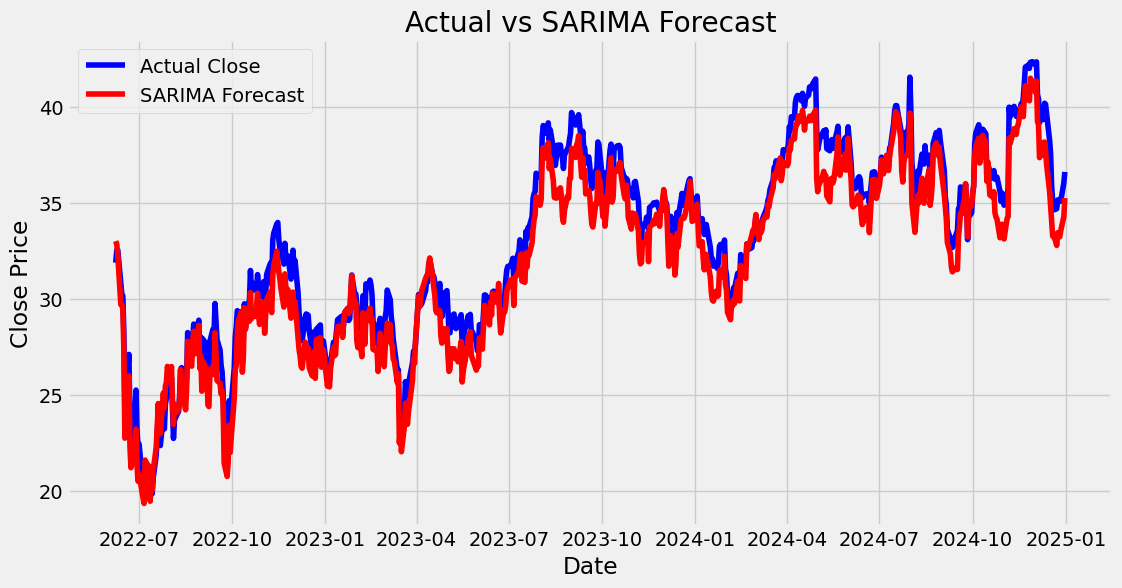

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_target.index, test_target, label='Actual Close', color='blue')
plt.plot(test_target.index, forecast_arima, label='SARIMA Forecast', color='red')
plt.title('Actual vs SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Prophet

Download Oil Data - external regressors

WTI Crude (CL=F) — This is the benchmark oil price in the U.S

In [ ]:
oil = yf.download('CL=F', start=starttime, end=endtime)
oil.reset_index(inplace=True)
newmerged = merged_data.copy()
newmerged.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
headers_as_rows = pd.DataFrame([oil.columns.tolist()])
cols = [col[0] for col in headers_as_rows.iloc[0].to_list()]
oil.columns = cols
oil.reset_index(inplace=True)

In [ ]:
oil.head()

,index,Date,Close,High,Low,Open,Volume
0,0,2012-01-03,102.959999,103.180000,99.650002,99.699997,275481
1,1,2012-01-04,103.220001,103.739998,101.879997,102.989998,271711
2,2,2012-01-05,101.809998,103.730003,101.300003,103.290001,295615
3,3,2012-01-06,101.559998,102.800003,100.879997,101.349998,290458
4,4,2012-01-09,101.309998,102.150002,100.099998,101.919998,311866


In [ ]:
newmerged = pd.merge(merged_data, oil[['Date', 'Close']], on='Date', how='left')
newmerged.head()

,Date,Close_x,High,Low,Open,Volume,ma_10,ma_50,daily_change,volatility_10,RSI_14,Momentum_10,Cumulative_Price_Volume,Cumulative_Volume,VWAP,Crude_Oil,Fed_Funds_Rate,Close_y
0,2012-03-14,193.902695,199.720641,193.034344,198.157607,76720,198.999916,213.447541,-0.023184,0.016184,31.039718,-11.983261,1.254141e+09,5893830,212.788800,105.49,0.13,105.430000
1,2012-03-15,190.950302,195.726231,189.560949,193.729035,112180,197.714757,212.943896,-0.015226,0.016413,20.491807,-12.851593,1.275562e+09,6006010,212.380902,105.19,0.13,105.110001
2,2012-03-16,192.166016,197.289280,190.168806,197.289280,133080,197.020078,212.320421,0.006367,0.015718,18.212507,-6.946793,1.301135e+09,6139090,211.942694,107.03,0.13,107.059998
3,2012-03-19,192.079193,195.292088,188.953138,194.857913,96380,196.368817,211.788990,-0.000452,0.015746,20.889783,-6.512604,1.319648e+09,6235470,211.635669,108.09,0.13,108.089996
4,2012-03-20,191.558167,197.028765,191.297659,197.028765,190980,196.021480,211.413863,-0.002713,0.014877,28.346476,-3.473373,1.356232e+09,6426450,211.039010,105.68,0.13,105.610001


In [ ]:
newmerged.rename(columns={'Close_x': 'NOG_Close', 'Close_y': 'Oil_Close'}, inplace=True)
df_prophet = newmerged[['Date', 'NOG_Close', 'Crude_Oil', 'Fed_Funds_Rate', 'Volume', 'Oil_Close']].dropna()
df_prophet.rename(columns={'Date': 'ds', 'NOG_Close': 'y'}, inplace=True)

Correlation

In [ ]:
newmerged[['NOG_Close', 'Oil_Close']].corr()

,NOG_Close,Oil_Close
NOG_Close,1.000000,0.648439
Oil_Close,0.648439,1.000000


64.84 % correlation between the NOG stock close price and the oil close price benchmark

In [ ]:
prophet = Prophet()
prophet.add_regressor('Oil_Close')
prophet_result = prophet.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdrhv7b9/yy92ff_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprdrhv7b9/unlns0ni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3101', 'data', 'file=/tmp/tmprdrhv7b9/yy92ff_k.json', 'init=/tmp/tmprdrhv7b9/unlns0ni.json', 'output', 'file=/tmp/tmprdrhv7b9/prophet_model4i4gqxgc/prophet_model-20250425223155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:31:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = prophet.make_future_dataframe(periods=30)
future['Oil_Close'] = df_prophet['Oil_Close'].iloc[-1]
forecast = prophet.predict(future)

In [ ]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3244,2025-01-26,62.881534,54.929708,71.148740
3245,2025-01-27,42.918147,34.567978,50.693804
3246,2025-01-28,43.010145,34.746034,51.758400
3247,2025-01-29,43.157705,34.695511,50.922215
3248,2025-01-30,43.271159,35.561249,51.869534


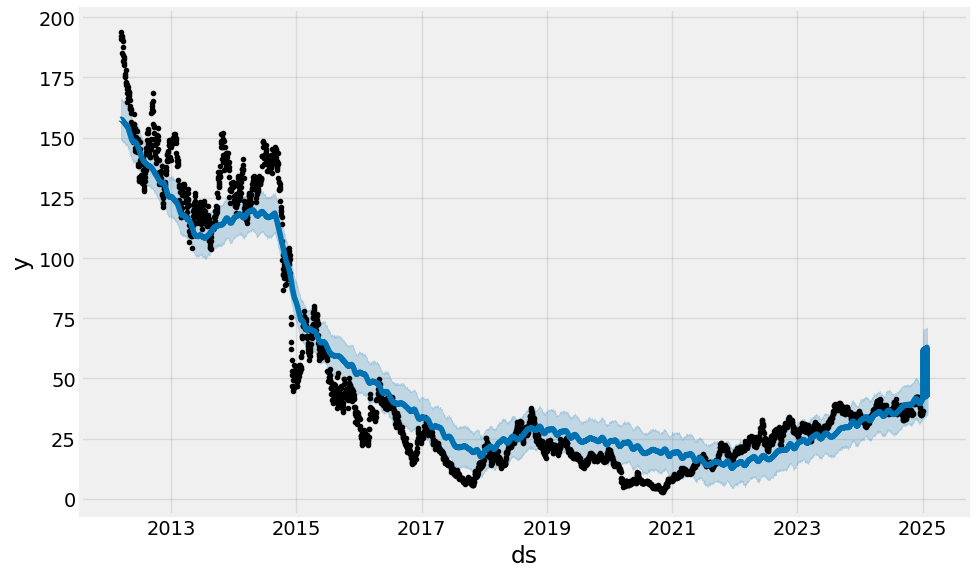

In [ ]:
prophet.plot(forecast);

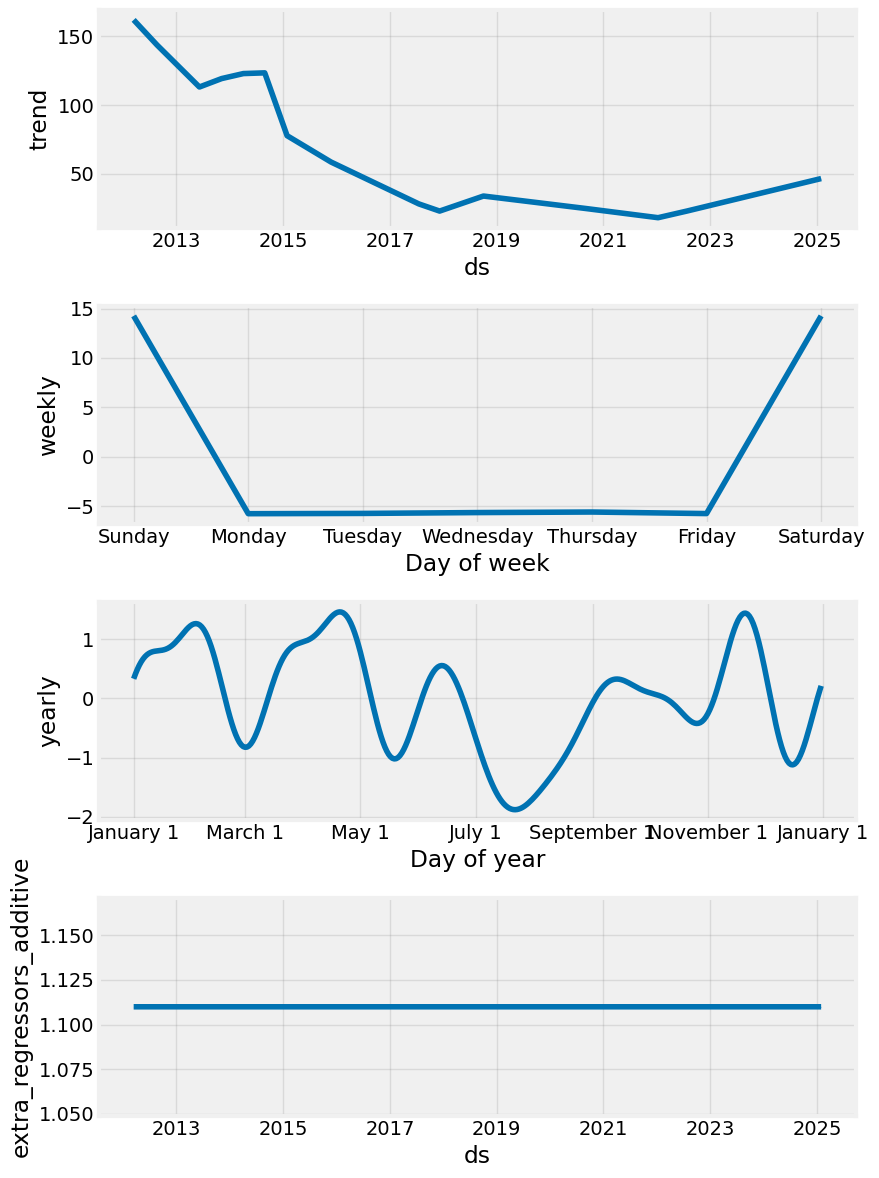

In [ ]:
prophet.plot_components(forecast);

In [ ]:
output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
output['actual'] = df_prophet[['y']].reindex(output['ds'])

<ipython-input-69-9cbb46f4ee50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['actual'] = df_prophet[['y']].reindex(output['ds'])


In [ ]:
df_prophet[['y', 'ds']]

,y,ds
0,193.902695,2012-03-14
1,190.950302,2012-03-15
2,192.166016,2012-03-16
3,192.079193,2012-03-19
4,191.558167,2012-03-20
...,...,...
3216,35.158348,2024-12-24
3217,35.187569,2024-12-26
3218,35.099915,2024-12-27
3219,36.045898,2024-12-30


# Multivariate LSTM

In [ ]:
features = ['Close','High','Low','Open','Volume','ma_10','ma_50',
            'daily_change','volatility_10','RSI_14','Momentum_10','VWAP','Crude_Oil','Fed_Funds_Rate']
data_lstm = merged_data[features + ['Date']].copy()
data_lstm.set_index('Date', inplace=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_lstm)

In [ ]:
def create_dataset(dataset, lookback=60):
  X, y = [], []
  for i in range(lookback, len(dataset)):
    X.append(dataset[i-lookback:i])
    y.append(dataset[i, 0])
  return np.array(X), np.array(y)

In [ ]:
lookback = 60
X, y = create_dataset(scaled_data, lookback)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0173
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 6.2726e-04
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 5.2993e-04
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 4.7626e-04
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 4.2823e-04
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 3.7506e-04
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 4.4792e-04
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 3.5562e-04
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.5883e-04
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 4.1148e-04
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 2.8924e-04
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.3194e-04
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.8151e-04
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 2.3927e-04
Epoch 15/20
79/79 ━

In [ ]:
# Inverse transform the predictions.
# Since we scaled all features, we need to reconstruct an array where only the first column differs.
predicted_lstm = lstm_model.predict(X_test)
dummy = np.zeros((predicted_lstm.shape[0], len(features)))
predicted_full = np.concatenate((predicted_lstm, dummy), axis=1)
y_test_extended = np.concatenate((y_test.reshape(-1, 1), dummy), axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
predicted_prices = scaler.inverse_transform(predicted_full)[:, 0]
actual_prices = scaler.inverse_transform(y_test_extended)[:,0]
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label="Actual Close", color='blue')
plt.plot(predicted_prices, label="LSTM Predicted Close", color='red')
plt.title("Multivariate LSTM Forecast for NOG Close Price")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (633,15) (14,) (633,15) 

In [ ]:
# import gspread
# from oauth2client.service_account import ServiceAccountCredentials
# from gspread_dataframe import set_with_dataframe
# import pandas as pd

In [ ]:
# # creds
# scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
# creds = ServiceAccountCredentials.from_json_keyfile_name("your_credentials.json", scope)
# client = gspread.authorize(creds)